> This notebook is intended to be used in Google Colab

In [292]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [293]:
directory = 'letters/'

# Parameters
img_height, img_width = 80, 60
batch_size = 32
epochs = 12
num_augmented_images = 200

images = []
labels = []

for filename in os.listdir(directory):
    if filename.endswith('.png'):
        img_path = os.path.join(directory, filename)
        label = filename.split('.')[0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        img = cv2.resize(img, (img_width, img_height))
        images.append(img)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

images = np.expand_dims(images, axis=-1)


R
(80, 60, 1)


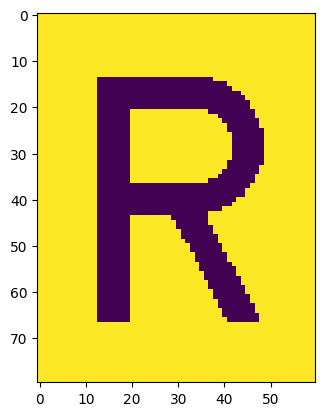

In [294]:
print(labels[0])
print(images[0].shape)
plt.imshow(images[0])

In [295]:
def label_to_index(label):
    if 'A' <= label <= 'Z':
        return ord(label) - ord('A')
    elif '0' <= label <= '9':
        return ord(label) - ord('0') + 26
    else:
        raise ValueError(f"Unsupported label: {label}")

labels = tf.keras.utils.to_categorical([label_to_index(label) for label in labels], num_classes=36)

def custom_preprocessing(image):
    kernel = np.ones((3,3), np.uint8)
    eroded_image = cv2.dilate(image, kernel, iterations=2)
    eroded_image = cv2.erode(image, kernel, iterations=1)
    img_array = eroded_image.reshape(eroded_image.shape + (1,))
    return img_array

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing
)

augmented_images = []
augmented_labels = []

for i, image in enumerate(images):
    img_array = image.reshape((1,) + image.shape)
    label = labels[i]

    j = 0
    for batch in datagen.flow(img_array, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        j += 1
        if j >= num_augmented_images:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

augmented_images = augmented_images / 255.0

x_train, x_val, y_train, y_val = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

In [296]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [297]:
import random

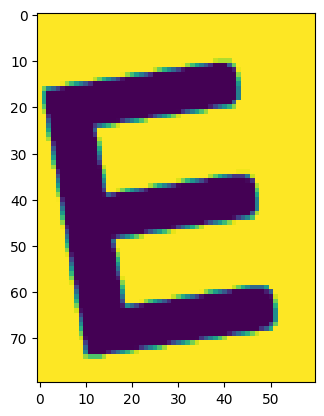

In [298]:
plt.imshow(x_train[random.randint(0, 150)])

In [299]:
# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(36, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/12
175/175 [==============================] - 38s 209ms/step - loss: 0.0790 - accuracy: 0.5389 - val_loss: 0.0212 - val_accuracy: 0.9286
Epoch 2/12
175/175 [==============================] - 39s 223ms/step - loss: 0.0088 - accuracy: 0.9773 - val_loss: 0.0063 - val_accuracy: 0.9829
Epoch 3/12
175/175 [==============================] - 36s 205ms/step - loss: 0.0023 - accuracy: 0.9968 - val_loss: 0.0045 - val_accuracy: 0.9900
Epoch 4/12
175/175 [==============================] - 39s 221ms/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 0.0034 - val_accuracy: 0.9921
Epoch 5/12
175/175 [==============================] - 35s 202ms/step - loss: 8.1853e-04 - accuracy: 0.9998 - val_loss: 0.0035 - val_accuracy: 0.9943
Epoch 6/12
175/175 [==============================] - 37s 211ms/step - loss: 8.5544e-04 - accuracy: 0.9987 - val_loss: 0.0025 - val_accuracy: 0.9950
Epoch 7/12
175/175 [==============================] - 35s 203ms/step - loss: 6.0587e-04 - accuracy: 0.9998 - val_loss: 0.0

In [300]:
model.save('ocr.keras')